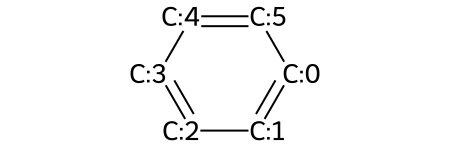

In [937]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

molecule = Chem.MolFromSmiles("c1ccccc1")
# molecule = Chem.MolFromSmiles("[cH-]1cccc1")

for atom in molecule.GetAtoms():
    # atom.SetProp("atomNote", str(atom.GetIdx())) # Can set atomNote to put atom index off to the side, but too small to read
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

molecule

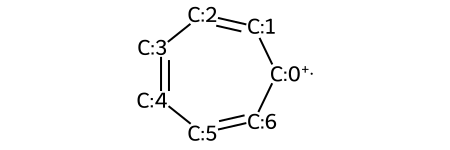

In [938]:
ion = Chem.MolFromSmiles("[C+]1C=CC=CC=C1")

for atom in ion.GetAtoms():
    # atom.SetProp("atomNote", str(atom.GetIdx())) # Can set atomNote to put atom index off to the side, but too small to read
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

ion

In [939]:
charge = Chem.GetFormalCharge(ion)

In [940]:
mol_weight = Descriptors.MolWt(ion)
mol_weight

90.12499999999999

In [941]:
Descriptors.ExactMolWt(ion)

90.04640161209

In [942]:
mcr = mol_weight / charge
mcr

90.12499999999999

In [943]:
def get_fraction(num, denom):
    if denom:
        return num / denom
    else:
        return None

In [944]:
get_fraction(mol_weight, charge)

90.12499999999999

In [945]:
get_fraction(Descriptors.MolWt(molecule), Chem.GetFormalCharge(molecule))

In [946]:
# Utilities
def flatten_twoD_list(twoD_list: list[list]) -> list:
    flat_list = []
    for row in twoD_list:
        for item in row:
            flat_list += [item]
    return flat_list

def longest_row(twoD_list: list[list]) -> int:
    return max(len(row) for row in twoD_list)

In [947]:
def mass_spec_frag_tree(non_bin_tree, verbose=False, **kwargs):
    """
    Draw a mass spectrometry fragmentation tree

    :returns: RDKit grid image, and (if verbose=True) fragment tree as 2D (nested) list
    :rtype: RDKit grid image, and (if verbose=True) molecules as list[list[mol]], labels as list[list[str]], mass (Daltons) as list[list[float]], m/z (mass-to-charge ratio) as list[list[float]]
    :param non_bin_tree: The NonBinTree corresponding to the parent compound
    :param verbose: Whether to return verbose output; default is False so calling this function will present a grid image automatically
    """
    smiles_grid, labels_grid = non_bin_tree.get_grid()
    row_length = longest_row(smiles_grid)

    smiles = flatten_twoD_list(smiles_grid)
    labels = flatten_twoD_list(labels_grid)
    # print(f"{smiles_grid=}")
    # print(f"{smiles=}")
    # print(f"{labels=}")

    # Convert SMILES into molecules
    mols_raw = [Chem.MolFromSmiles(smile) for smile in smiles]
    mols = [Chem.AddHs(mol_raw) for mol_raw in mols_raw]
    
    # molecule = Chem.MolFromSmiles(smiles)
    # RecapHierarchy = Recap.RecapDecompose(molecule)
    # root = NonBinTree(RecapHierarchy.smiles)
    # molecule_nonbinary_tree = get_children(RecapHierarchy, root)
    # fragment_grid = molecule_nonbinary_tree.get_grid()
    # mols_per_row = len(fragment_grid[0])
    # recap_plot = [item for sublist in fragment_grid for item in sublist]
    # recap_labels = [item for sublist in fragment_grid for item in sublist]
    # if name:
    #     recap_labels[0] = name
    drawing = Draw.MolsToGridImage(mols, legends=labels, molsPerRow=row_length, **kwargs)
    if verbose:
        ...
    #       return drawing, molecule, RecapHierarchy, molecule_nonbinary_tree, fragment_grid
    else:
          return drawing

In [948]:
def concat_grids_horizontally(grid1:list[list[str]], grid2:list[list[str]]) -> list[list[str]]:
    """Concatenate two nested lists horizontally, for example
    inputs [['a'],['b'],['c']] and [['d'], ['e'], ['f']] 
    produce [['a', 'd'], ['b', 'e'], ['c', 'f']]

    :returns: The combined grid, a two-deep nested list of strings
    :param grid1: The first grid, a two-deep nested list of strings
    :param grid2: The second grid, a two-deep nested list of strings
    """
    if grid1 == [[]]:
        combined = grid2
    elif grid2 == [[]]:
        combined = grid1
    else:
        combined = []
        for row_counter in range(len(grid1)):
            combined += [grid1[row_counter] + grid2[row_counter]]
    return combined

class NonBinTree:
    """
    Nonbinary tree class
    Note that this class is not designed to sort nodes as they are added to the tree;
    the assumption is that they should be ordered in the order added
    Adapted from https://stackoverflow.com/questions/60579330/non-binary-tree-data-structure-in-python#60579464
    """

    def __init__(self, val:str, label=None):
        """Create a NonBinTree instance"""
        self.val = val
        self.label = label
        self.nodes = []

    def add_node(self, val:str, label=None):
        """Add a node to the tree and return the new node"""
        self.nodes.append(NonBinTree(val, label))
        return self.nodes[-1]

    def __repr__(self) -> str:
        """Print out the tree as a nested list"""
        return f"NonBinTree({self.val}): {self.nodes}"

    def get_ncols(self) -> int:
        """Get the number of columns in the tree"""
        self.ncols = 0
        if len(self.nodes) > 0:
            # If there are nodes under this one, call get_ncols on them recursively
            for node in self.nodes:
                self.ncols += node.get_ncols()
        else:
            # If there are no nodes under this one, add 1 for this node
            self.ncols += 1
        return self.ncols

    def get_max_depth(self) -> int:
        """Get the maximum depth of the tree"""
        max_depth = 0
        if len(self.nodes) > 0:
            for node in self.nodes:
                this_depth = node.get_max_depth()
                max_depth = max(this_depth + 1, max_depth)
        else:
            max_depth = max(1, max_depth)
        self.max_depth = max_depth
        return self.max_depth

    def get_grid(self) -> list[list[str]]:
        """
        Get a two-dimensional grid where
        each row is a level in the fragment hierarchy, and
        the columns serve to arrange the fragments horizontally
        """
        # Call methods to calculate self.ncols and self.max_depth
        self.get_ncols()
        self.get_max_depth()

        # Create top row: Node value, then the rest of columns are blank (empty strings)
        grid = [[self.val] + [""] * (self.ncols - 1)]
        grid_label = [[self.label] + [""] * (self.ncols - 1)]

        n_nodes = len(self.nodes)

        if n_nodes > 0:
            nodes_grid = [[]]
            nodes_grid_label = [[]]

            # Iterate through the chile nodes
            for node_counter, node in enumerate(self.nodes):
                # Recursively call this function to get the grid for children
                node_grid, node_grid_label = node.get_grid()

                # Add spacer rows if needed
                node_grid_rows = len(node_grid)
                rows_padding = self.max_depth - node_grid_rows - 1
                for padding in range(rows_padding):
                    padding_to_add = [[""] * len(node_grid[0])]
                    node_grid += padding_to_add
                    node_grid_label += padding_to_add

                nodes_grid = concat_grids_horizontally(nodes_grid, node_grid)
                nodes_grid_label = concat_grids_horizontally(nodes_grid_label, node_grid_label)

            grid += nodes_grid
            grid_label += nodes_grid_label

        return grid, grid_label

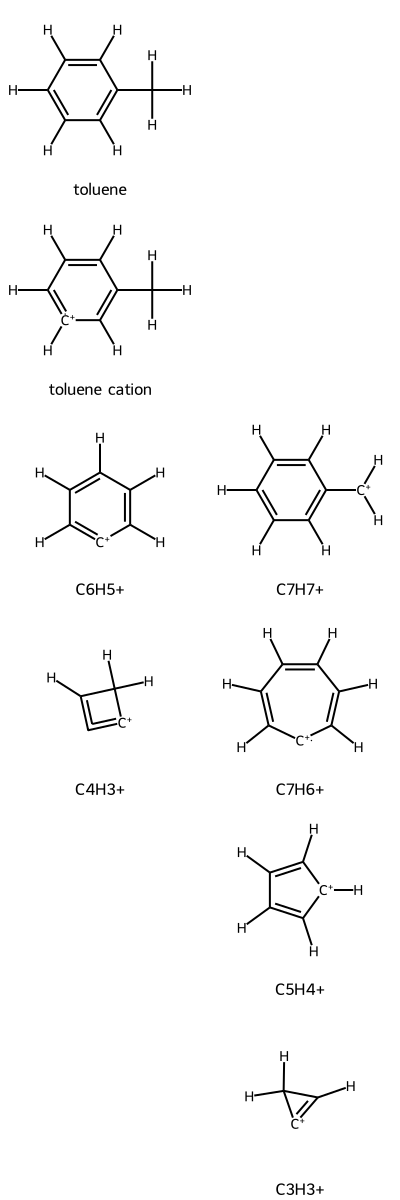

In [949]:
# Create mass spectrometry fragmentation tree
toluene = NonBinTree("Cc1ccccc1", "toluene")
toluene_cation = toluene.add_node("CC1=C[CH+]=CC=C1", "toluene cation")
C6H5_cation = toluene_cation.add_node("[C+]1=CC=CC=C1", "C6H5+")
C4H3_cation = C6H5_cation.add_node("[C+]1=C=CC1", "C4H3+")

C7H7_hex_ring_cation = toluene_cation.add_node("[CH2+]c1ccccc1", "C7H7+")
C7H7_hept_ring_cation = C7H7_hex_ring_cation.add_node("[C+]1C=CC=CC=C1", "C7H6+")
C5H5_cation = C7H7_hept_ring_cation.add_node("[CH+]1C=CC=C1", "C5H4+")
C3H3_cation = C5H5_cation.add_node("[C+]1=CC1", "C3H3+")

nbt = mass_spec_frag_tree(toluene)
nbt

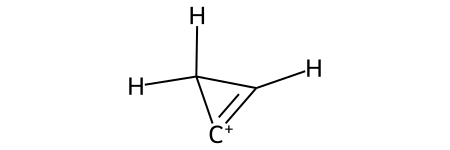

In [950]:
a = Chem.AddHs(Chem.MolFromSmiles(C3H3_cation.val))
a

In [951]:
Descriptors.ExactMolWt(a)

39.022926516089996

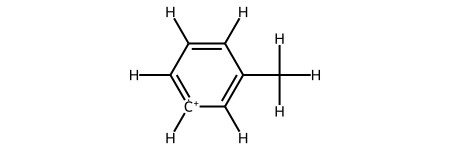

In [952]:
toluene_anion = "CC1=C[CH+]=CC=C1"
b = Chem.AddHs(Chem.MolFromSmiles(toluene_anion))
b

In [953]:
Descriptors.ExactMolWt(b)

92.06205167609